<h1>
    Filter Test 
</h1>

Import the filter functions implemented in C, along with helper functions for plotting.


In [1]:
from ctypes import CDLL
from ctypes import POINTER
from ctypes import c_int
from ctypes import c_float
from ctypes import c_void_p
from ctypes import Structure

FILTER_LOWPASS = 0
FILTER_HIGHPASS = 1
FILTER_PEAKING = 2

class user_params(Structure):
    _fields_ = [
     ("type", c_int),
     ("f0", c_float),
     ("dbGain", c_float),
     ("BW", c_float),
    ]

_filter = CDLL('lib/libfilters.so')

lowpass = _filter.lowpass
lowpass.argtypes = [POINTER(c_float), POINTER(c_float), user_params]
lowpass.restype = c_float

filter = _filter.filter
filter.argtypes = [POINTER(c_float), POINTER(c_float), c_int, user_params]
filter.restype = c_void_p

get_params = _filter.get_params
get_params.argtypes = [c_int, c_int, c_int, c_float]
get_params.restype = user_params


import IPython.display as ipd
import numpy as np
from matplotlib import pyplot as plt

def plotEq(f_x, x_arr, title, xlabel, ylabel):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_arr, f_x)
    plt.ylim(-15,15)
    plt.xlim(0,500)

def plotDTFT(f_x, x_arr, title, xlabel, ylabel, max_A):
    X, w = DTFT(f_x, 512)
    w = (w * 48000) / (2*np.pi)
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(w, (np.abs(X)))
    plt.ylim(0,max_A)
    plt.xlim(0,1000)

def DTFT(x, M):
    """
    Parameters:
    ---
    x: a signal which is assumed to start at time n = 0
    M: the number of output points of the DTFT

    Returns:
    ---
    X: the samples of the DTFT
    w: corresponding frequencies of these samples
    """
    N = max(M, len(x))
    N = int(np.power(2, np.ceil(np.log(N) / np.log(2))))
    X = np.fft.fft(x, N)
    w = np.arange(N) / N * 2 * np.pi
    w = w - 2 * np.pi * (w >= np.pi).astype(int)
    X = np.fft.fftshift(X)
    w = np.fft.fftshift(w)
    return X, w

<h1>Generated Sine Waves</h1>

Generate two sine waves at different frequencies to then combine them into a noise signal to filter. 

In [2]:
duration = 2   # duration of the signal in seconds
sample_rate = 48000  # samples per second

t = np.linspace(0, duration, int(sample_rate * duration)) # time samples

A_1 = 1.0  # amplitude 1
A_2 = 1.0  # amplitude 2

f_1  = 200.0  # frequency 1 
f_2  = 900.0  # frequency 2

y = A_1 * np.sin(2 * np.pi * f_1 * t)
z = A_2 * np.sin(2 * np.pi * f_2 * t) 

c_noisy_signal = (c_float * len(t))()
c_filtered_signal = (c_float * len(t))()

for i in range(len(t)):
    c_noisy_signal[i] = y[i] + z[i]
    c_filtered_signal[i] = 0.0

noisy_signal = np.array(c_noisy_signal)

params = get_params(FILTER_LOWPASS, 300, 0, 10)
filter(c_noisy_signal, c_filtered_signal, len(t), params)
filtered_signal = np.array(c_filtered_signal)

<h2>Plots</h2>

Plot the wave in the time domain.

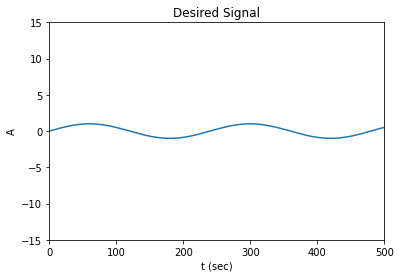

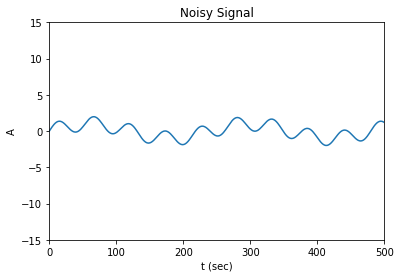

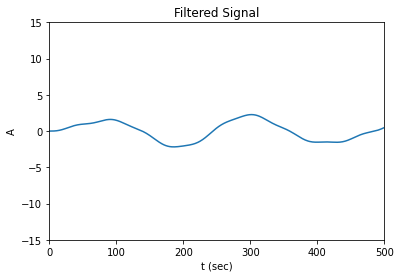

In [3]:
plotEq(y, np.arange(len(t)), "Desired Signal","t (sec)","A")
# plotEq(z, np.arange(len(t)), "Signal Z","t (sec)","A")
plotEq(noisy_signal, np.arange(len(t)), "Noisy Signal","t (sec)","A")
plotEq(filtered_signal, np.arange(len(t)), "Filtered Signal","t (sec)","A")

Plot the frequency spectrum of the signals.

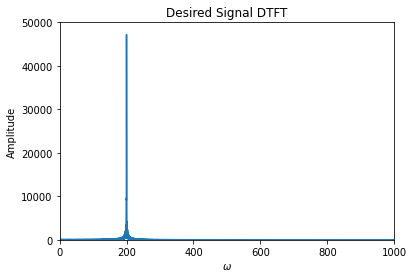

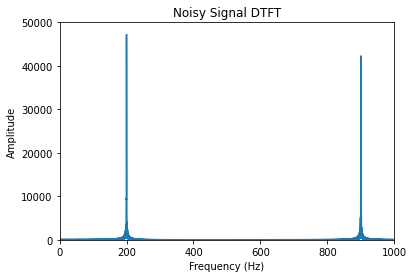

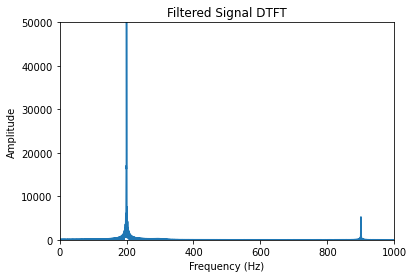

In [4]:
plotDTFT(y, np.arange(len(t)), "Desired Signal DTFT","$\omega$","Amplitude", 50000)
# plotDTFT(z, np.arange(len(t)), "Signal Z DTFT","$\omega$","Amplitude", 50000)
plotDTFT(noisy_signal, np.arange(len(t)), "Noisy Signal DTFT","Frequency (Hz)","Amplitude", 50000)
plotDTFT(filtered_signal, np.arange(len(t)), "Filtered Signal DTFT","Frequency (Hz)","Amplitude", 50000)

<h2>Audio</h2>

Play the audio of the signals.

In [5]:
ipd.display(ipd.Audio(y, rate=sample_rate))
# ipd.display(ipd.Audio(z, rate=sample_rate))
ipd.display(ipd.Audio(noisy_signal, rate=sample_rate))
ipd.display(ipd.Audio(filtered_signal, rate=sample_rate))